In [82]:
%matplotlib inline
import numpy as np

from scipy.integrate import solve_ivp

from sympy import Matrix, lambdify, symbols, sin, cos
from sympy.solvers.solveset import linsolve
from sympy.physics.mechanics import dynamicsymbols, init_vprinting

import matplotlib.pyplot as plt

init_vprinting()

In [83]:
q1, q2 = dynamicsymbols('q_1 q_2')
t = symbols('t')

"numerical values"
l1, m1, l2, m2, g = 1, 1, 1, 1, 9.81
beta01, gamma01, beta12, gamma12 = 450, 300, 200, 300
params =             (q1       ,  q1.diff(),  q2     ,  q2.diff())
initial_conditions = (-np.pi/18,  0        ,  np.pi/6,  0        )
q1f, q2f = np.pi/6, np.pi/3
IC1, IC2 = m1*l1**2/12, m2*l2**2/12

"feedback control"
T01 = Matrix([0, 0, -beta01*q1.diff() - gamma01*(q1-q1f) + 0.5*g*l1*m1*cos(q1) + g*l1*m2*cos(q1)])
T02 = Matrix([0, 0, -beta12*q2.diff() - gamma12*(q2-q2f) + 0.5*g*l2*m2*cos(q2)])

In [84]:
omg1 = Matrix([0, 0, q1.diff()])
omg2 = Matrix([0, 0, q2.diff()])
alp1 = omg1.diff()
alp2 = omg2.diff()

"PVA of rC1, rC2"
# position
rC1 = l1/2 * Matrix([cos(q1), sin(q1), 0])
rC2 = 2*rC1 + l2/2 * Matrix([cos(q2), sin(q2), 0])

# acceleration
aC1 = rC1.diff(t, 2)
aC2 = rC2.diff(t, 2)

In [85]:
"Force Analysis of rC1, rC2"
# gravity
G1 = Matrix([0, -m1*g, 0])
G2 = Matrix([0, -m2*g, 0])

# the forces/moments acting on link 2 are G2, T02, F12, T12
F12 = m2*aC2 - G2
rBC2 = 2*rC1 - rC2
T12 = -IC2*alp2 + T02 + rBC2.cross(F12) # center of moment at C2

# the forces/moments acting on link 1 are G1, T01, F21, T21, F01, M_reaction
F01 = m1*aC1 - G1 - (-F12)
M = -IC1*alp1 + T01 + (-T12) + (-rC1).cross(F01) + rC1.cross(-F12) # center of moment at C1

sol = list(linsolve((T12[2], M[2]), (alp1[2], alp2[2])))[0]

In [86]:
dq1 = lambdify(params, q1.diff())
ddq1 = lambdify(params, sol[0])
dq2 = lambdify(params, q2.diff())
ddq2 = lambdify(params, sol[1])

fun = lambda t, y: [dq1(*y), ddq1(*y), dq2(*y), ddq2(*y)]
time_interval = [0, 10]
res = solve_ivp(fun, time_interval, initial_conditions,
                t_eval=np.linspace(*time_interval, 10000))

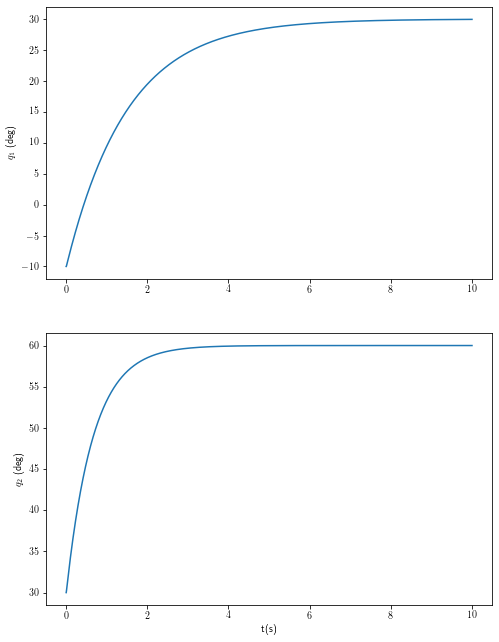

In [91]:
fig, ax = plt.subplots(nrows=2, figsize=(8,11))
ax[0].plot(res.t, res.y[0]*180/np.pi)
ax[0].set_ylabel(r'$q_1$ (deg)')
ax[1].plot(res.t, res.y[2]*180/np.pi)
ax[1].set_ylabel(r'$q_2$ (deg)')
ax[1].set_xlabel('t(s)')
plt.savefig('2-link-robot_q1_q2.png', dpi=600)